In [1]:
import torch
import dataclasses
import mediapy
from huggingface_hub import PyTorchModelHubMixin
from huggingface_hub import ModelCard
from gpudrive.networks.late_fusion import NeuralNet
import matplotlib.pyplot as plt
from collections import defaultdict
import random
import torch
import random
import numpy as np
import pandas as pd

from gpudrive.env.config import EnvConfig
from gpudrive.env.env_torch import GPUDriveTorchEnv
from gpudrive.visualize.utils import img_from_fig
from gpudrive.env.dataset import SceneDataLoader
from gpudrive.utils.config import load_config
from gpudrive.utils.checkpoint import load_policy
from gpudrive.utils.rollout import rollout

from PIL import Image

In [2]:
# Configs model has been trained with
config = load_config("/home/emerge/gpudrive/baselines/ppo/config/ppo_base_puffer")

print(config)

num_envs = 5
device = "cpu"
max_agents = 64

config.environment.reward_type = "reward_conditioned"
config.environment.condition_mode = "fixed"
config.environment.agent_type = torch.Tensor([-0.2, 1.0, -0.2])

{'mode': 'train', 'use_rnn': False, 'eval_model_path': None, 'baseline': False, 'data_dir': 'data/processed/training', 'continue_training': False, 'model_cpt': None, 'environment': {'name': 'gpudrive', 'num_worlds': 75, 'k_unique_scenes': 75, 'max_controlled_agents': 64, 'ego_state': True, 'road_map_obs': True, 'partner_obs': True, 'norm_obs': True, 'remove_non_vehicles': False, 'lidar_obs': False, 'reward_type': 'reward_conditioned', 'collision_weight': -0.75, 'off_road_weight': -0.75, 'goal_achieved_weight': 1.0, 'condition_mode': 'random', 'collision_weight_lb': -3.0, 'collision_weight_ub': 0.5, 'goal_achieved_weight_lb': 1.0, 'goal_achieved_weight_ub': 3.0, 'off_road_weight_lb': -3.0, 'off_road_weight_ub': 0.0, 'dynamics_model': 'classic', 'collision_behavior': 'ignore', 'dist_to_goal_threshold': 2.0, 'polyline_reduction_threshold': 0.1, 'sampling_seed': 42, 'obs_radius': 50.0, 'action_space_steer_disc': 13, 'action_space_accel_disc': 7}, 'wandb': {'entity': '', 'project': 'kshotag

In [3]:
agent = load_policy(
    model_name="model_PPO____R_10000__03_19_19_05_33_518_006000",
    path_to_cpt="/home/emerge/gpudrive/examples/experimental/models",
    env_config=config.environment,
    device=device
);

Load model from /home/emerge/gpudrive/examples/experimental/models/model_PPO____R_10000__03_19_19_05_33_518_006000.pt


In [4]:
# Create data loader
train_loader = SceneDataLoader(
    root='/home/emerge/gpudrive/data/processed/training/',
    batch_size=num_envs,
    dataset_size=100,
    sample_with_replacement=False,
)

# Set params
config = config.environment
env_config = dataclasses.replace(
    EnvConfig(),
    norm_obs=config.norm_obs,
    dynamics_model=config.dynamics_model,
    collision_behavior=config.collision_behavior,
    dist_to_goal_threshold=config.dist_to_goal_threshold,
    polyline_reduction_threshold=config.polyline_reduction_threshold,
    remove_non_vehicles=config.remove_non_vehicles,
    lidar_obs=config.lidar_obs,
    disable_classic_obs=config.lidar_obs,
    obs_radius=config.obs_radius,
    steer_actions = torch.round(
        torch.linspace(-torch.pi, torch.pi, config.action_space_steer_disc), decimals=3  
    ),
    accel_actions = torch.round(
        torch.linspace(-4.0, 4.0, config.action_space_accel_disc), decimals=3
    ),
    reward_type=config.reward_type,
    condition_mode=config.condition_mode,
    agent_type=config.agent_type,
)

# Make env
env = GPUDriveTorchEnv(
    config=env_config,
    data_loader=train_loader,
    max_cont_agents=64, #config.max_controlled_agents,
    device=device,
)

In [5]:
def run_multiple_rollouts(env, agent, num_rollouts=2, device='cpu'):
    """
    Run multiple rollouts with different collision weights and store trajectories.
    Stores agent positions as a tensor of shape [num_envs, num_rollouts, agents, steps, 2].
    
    Args:
        env: The environment (can be batched with multiple environments)
        agent: The policy
        num_rollouts: Number of rollouts to perform
        device: Device to run on
        
    Returns:
        all_trajectories: Dictionary containing trajectories and weights
    """
    
    # Get environment info to determine dimensions
    obs = env.reset(agent_type=torch.Tensor([0.0, 0.0, 0.0]))
    num_envs = obs.shape[0] if hasattr(obs, 'shape') else 1
    
    # Lists to collect data across rollouts
    all_agent_positions = []
    collision_weights = []
    goal_weights = []
    offroad_weights = []
    all_goal_achieved = []
    all_collided = []
    all_off_road = []
    all_episode_lengths = []
    
    for i in range(num_rollouts):
        print(f"Running rollout {i+1}/{num_rollouts}")
        
        # Sample separate weights
        collision_weight = random.uniform(-3.0, 1.0)
        goal_weight = 1.0
        off_road_weight = -3.0
        
        agent_weights = torch.Tensor([collision_weight, goal_weight, off_road_weight])
        print(f"Using weights: {agent_weights}")
        
        # Run rollout with these weights
        (
            goal_achieved_count,
            frac_goal_achieved,
            collided_count,
            frac_collided,
            off_road_count,
            frac_off_road,
            not_goal_nor_crash_count,
            frac_not_goal_nor_crash_per_scene,
            controlled_agents_per_scene,
            sim_state_frames,
            agent_positions,
            episode_lengths
        ) = rollout(
            env=env,
            policy=agent,
            device=device,
            deterministic=False,
            return_agent_positions=True,
            set_agent_type=True,
            agent_weights=agent_weights,
        )
        
        # Store weights and positions
        collision_weights.append(collision_weight)
        goal_weights.append(goal_weight)
        offroad_weights.append(off_road_weight)
        all_agent_positions.append(agent_positions.clone().detach())
        
        # Store other metrics
        all_goal_achieved.append(goal_achieved_count)
        all_collided.append(collided_count)
        all_off_road.append(off_road_count)
        all_episode_lengths.append(episode_lengths)
    
    # Stack agent positions along a new dimension at position 1 (after num_envs)
    # From list of [num_envs, num_agents, time_steps, 2] to tensor of [num_envs, num_rollouts, num_agents, time_steps, 2]
    stacked_positions = torch.stack(all_agent_positions, dim=1)
    
    # Return organized data
    all_trajectories = {
        'collision_weights': torch.tensor(collision_weights),
        'goal_weights': torch.tensor(goal_weights),
        'offroad_weights': torch.tensor(offroad_weights),
        'agent_positions': stacked_positions,  # Shape: [num_envs, num_rollouts, num_agents, time_steps, 2]
        'goal_achieved': all_goal_achieved,
        'collided': all_collided,
        'off_road': all_off_road,
        'episode_lengths': all_episode_lengths
    }
    
    return all_trajectories

In [6]:
trajs = run_multiple_rollouts(
    env=env,
    agent=agent,
    num_rollouts=20,
    device='cpu'
);

Running rollout 1/20
Using weights: tensor([-1.6067,  1.0000, -3.0000])
Running rollout 2/20
Using weights: tensor([-0.4170,  1.0000, -3.0000])
Running rollout 3/20
Using weights: tensor([-2.7621,  1.0000, -3.0000])
Running rollout 4/20
Using weights: tensor([-0.1729,  1.0000, -3.0000])
Running rollout 5/20
Using weights: tensor([-1.8213,  1.0000, -3.0000])
Running rollout 6/20
Using weights: tensor([-2.4634,  1.0000, -3.0000])
Running rollout 7/20
Using weights: tensor([-0.8697,  1.0000, -3.0000])
Running rollout 8/20
Using weights: tensor([-1.1699,  1.0000, -3.0000])
Running rollout 9/20
Using weights: tensor([-2.5592,  1.0000, -3.0000])
Running rollout 10/20
Using weights: tensor([ 0.8334,  1.0000, -3.0000])
Running rollout 11/20
Using weights: tensor([-0.6398,  1.0000, -3.0000])
Running rollout 12/20
Using weights: tensor([ 0.2693,  1.0000, -3.0000])
Running rollout 13/20
Using weights: tensor([ 0.7411,  1.0000, -3.0000])
Running rollout 14/20
Using weights: tensor([-0.5354,  1.000

In [7]:
trajs['agent_positions'].shape

torch.Size([5, 20, 64, 91, 2])

In [8]:
trajs['collision_weights']

tensor([-1.6067, -0.4170, -2.7621, -0.1729, -1.8213, -2.4634, -0.8697, -1.1699,
        -2.5592,  0.8334, -0.6398,  0.2693,  0.7411, -0.5354, -2.0566, -0.8910,
         0.9948, -2.7536, -0.5967, -0.0391])

/home/emerge/gpudrive/gpudrive/visualize/core.py:376: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout(pad=2, rect=[0.00, 0.00, 0.9, 1])


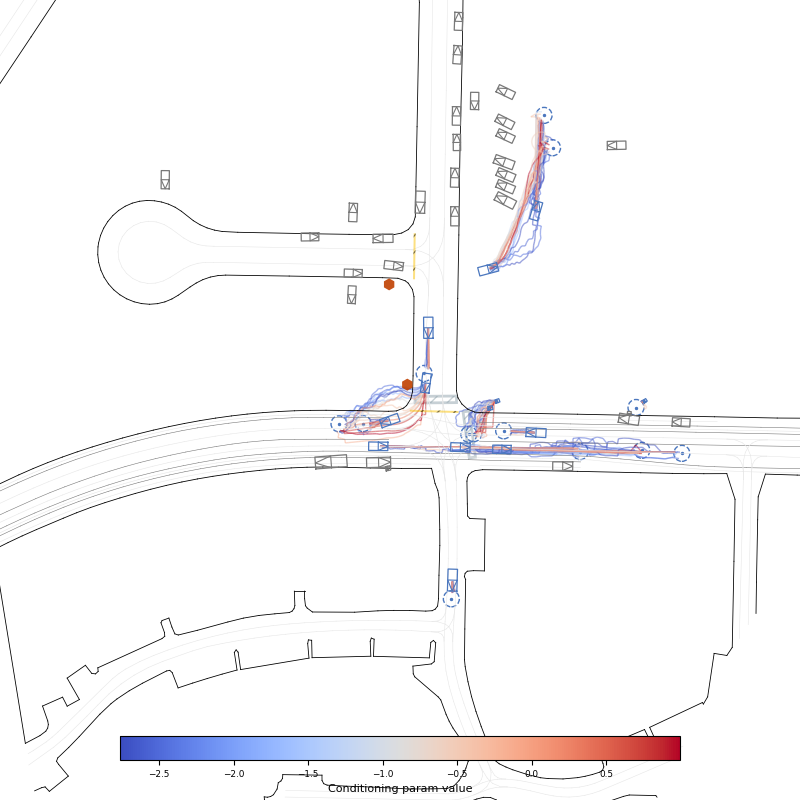

In [9]:
env.vis.figsize = (8, 8)

# Plot simulator state with the stacked trajectories
_ = env.reset(agent_type=torch.Tensor([-0.2, 1.0, -0.2]))
img = env.vis.plot_simulator_state(
    env_indices=[4], 
    agent_positions=trajs['agent_positions'],  # Pass stacked trajectories directly
    zoom_radius=100,
    multiple_rollouts=True,
    line_alpha=0.5,          
    line_width=1.0,     
    weights=trajs['collision_weights'],     
    colorbar=True, 
)[0]

Image.fromarray(img_from_fig(img))

In [10]:
# Save the figure with high DPI
fig = img  # Since img is already the figure object
filename = "effect_of_rew_cond_2.png"
fig.savefig(filename, dpi=300, bbox_inches='tight', pad_inches=0.1)
print(f"Figure saved as {filename}")

Figure saved as effect_of_rew_cond_2.png


### Analyze diversity

In [13]:
def collect_rollout_data(env, policy, agent_weights, device, num_rollouts=5):
    """
    Collect behavioral data from multiple rollouts for a specific agent type.
    
    Args:
        env: The simulation environment
        policy: The policy to be rolled out
        agent_weights: Agent weight tensor for this agent type
        device: Device to run computations on
        num_rollouts: Number of rollouts to perform
        
    Returns:
        dict: Collected behavioral data from all rollouts
    """
    # Initialize data collection
    all_situation_responses = {}
    
    # Perform multiple rollouts
    for rollout_idx in range(num_rollouts):
        print(f"  Rollout {rollout_idx+1}/{num_rollouts}")
        
        # Run rollout with behavior metrics collection
        rollout_results = rollout(
            env=env,
            policy=policy,
            device=device,
            deterministic=False,
            render_sim_state=False,
            return_agent_positions=False,
            return_behavior_metrics=True,
            set_agent_type=True,
            agent_weights=agent_weights
        )
        
        # Extract behavior metrics (last element of returned tuple)
        behavior_metrics = rollout_results[-1]
        
        # Merge situation responses
        for sit_key, responses in behavior_metrics['situation_responses'].items():
            if sit_key not in all_situation_responses:
                all_situation_responses[sit_key] = []
            all_situation_responses[sit_key].extend(responses)
    
    return {
        'situation_responses': all_situation_responses,
        'entropy_values': behavior_metrics['entropy_values'],
        'logprob_values': behavior_metrics['logprob_values']
    }


def store_data_to_dataframe(agent_types, collected_data):
    """
    Store collected agent behavioral data in a pandas DataFrame.
    
    Args:
        agent_types: List of agent types/names
        collected_data: Dictionary mapping agent types to their behavioral data
        
    Returns:
        pd.DataFrame: DataFrame containing all the behavioral data
    """
    # Create lists to store the flattened data
    rows = []
    
    # Process each agent type's data
    for agent_idx, agent_type in enumerate(agent_types):
        agent_data = collected_data[agent_type]
        
        # Process situation responses
        for sit_key, responses in agent_data['situation_responses'].items():
            for response in responses:
                # Create a row for this response
                row = {
                    'agent_type': agent_type,
                    'agent_idx': agent_idx,
                    'world_idx': response['world_idx'],
                    'agent_id': response['agent_idx'],
                    'situation_key': hash(sit_key),  # Use hash as pandas doesn't handle tuples well
                    'action': response['action'],
                    'entropy': response['entropy'] if 'entropy' in response else None,
                    'logprob': response['logprob'] if 'logprob' in response else None,
                    'time_step': response['time_step']
                }
                rows.append(row)
    
    # Convert to DataFrame
    df = pd.DataFrame(rows)
    
    # Print some basic statistics
    print(f"\nDataFrame created with {len(df)} rows")
    print(f"Number of unique situations: {df['situation_key'].nunique()}")
    print(f"Number of unique agent types: {df['agent_type'].nunique()}")
    
    return df

In [14]:
agent_configs = {
    'Nominal': torch.tensor([-0.5, 0.1, -0.5], device=device),
}

print("Collecting rollout data...")
collected_data = {}

agent_weights = torch.Tensor([-0.2, 1.0, -0.2])


div_metrics = collect_rollout_data(
    env, agent, agent_weights, device, 2
)

#df = store_data_to_dataframe(list(agent_configs.keys()), collected_data)


  Rollout 1/2
  Rollout 2/2


In [16]:
div_metrics.keys()

dict_keys(['situation_responses', 'entropy_values', 'logprob_values'])

In [18]:
div_metrics['entropy_values'].shape

torch.Size([5, 64, 91])